In [1]:
import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('Seaborn version:', sns.__version__)

from sklearn.impute import SimpleImputer, KNNImputer

from datetime import datetime, timedelta

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2
Seaborn version: 0.12.1


In [2]:
#import logging
#import sys

#logger = logging.getLogger() # create handler only, from classes use getLogger(<name>)
#logger.setLevel(logging.DEBUG)

#handler = logging.StreamHandler(stream=sys.stdout)
#handler.setFormatter(logging.Formatter(fmt='[%(asctime)s: %(name)s.%(funcName)s: %(levelname)s] %(message)s'))
#logger.addHandler(handler)

## 1. General pipeline steps sequence

1. transform and separate target values ('y' -> [0, 1])
2. drop unnecessary features
3. group / bin features:  
    - group job
    - group education
    - bin age
4. Encode values:
    - age: (1) leave as it is, (2) bin and WoE encode
    - job: (1) OrdinalEncoder, (2) OneHot, (3) WoE encode with 'unknown' as category, (4) WoE encode + impute 'unknown' lately
    - marital: (1) OrdinalEncoder, (2) OneHot, (3) WoE encode with 'unknown' as category, (4) WoE encode + impute 'unknown' lately
    - education: (1) OrdinalEncoder, (2) OneHot, (3) WoE encode with 'unknown' as category, (4) WoE encode + impute 'unknown' lately
    - default: (1) drop, (2) WoE encode, (3) unknown->no + one-hot encode
    - housing: (1) yes->1, no->0, unknown->1, (2) WoE encode, (3) drop
    - loan: (1) yes->1, no->0, unknown->0, (2) WoE encode, (3) drop
    - contact: (1) cellular->1, telephone->0, (2) WoE encode
    - month: (1) month number encode, (2) WoE encode, (3) num_of_positives encode, (4) drop
    - day_of_week: (1) dow number encode, (2) WoE encode, (3) num_of_positives encode, (4) drop
    - duration: ???
    - campaign: (1) do nothing, (2) cutoff with Q3+1.5*IQR only, (3) cutoff and WoE encode
    - pdays: (1) do nothing, (2) cutoff with Q3+1.5*IQR only, (3) cutoff and WoE encode, (4) bin and WoE encode, (5) drop
    - previous: (1) do nothing, (2) group [3..7]->3 only, (3) group [3..7] and WoE encode, (4) group [1..7]->1 only, (5) group[1..7] and WoE encode, (6) drop
    - poutcome: (1) encode by OrdinalEncoder with nonexistent->0, success=1, failure=-1, (2) WoE encode, (3) drop
    - all other features remain as they are
5. Impute:
    - job: (1) cross-impute education->job, (2) most_frequent, (3) KNN, (4) IterativeImputer
    - education: (1) cross-impute job->education, (2) most_frequent, (3) KNN, (4) IterativeImputer
    - marital: (1) cross-impute age[_binned]->marital, (2) most_frequent, (3) KNN, (4) IterativeImputer
    - default: (1) most_frequent, (2) KNN, (3) IterativeImputer
    - housing: (1) most_frequent, (2) KNN, (3) IterativeImputer
    - loan: (1) most_frequent, (2) KNN, (3) IterativeImputer
6. MinMaxScaler / StandardScaler if necessary before using in model
7. [!!!] Oversample positive class

Alternative encodings: (1) mean target value for category, (2) num_of_positives

Atomic preprocessing operations:  
1. Drop => DFDropColumns
2. Bin => DFColumnBinning
3. Encode by OrdinalEncoder
4. Encode by OneHotEncoder
5. Encode with boolean (single true/false column) <-> mapping values => DFValuesMapper
6. Encode WoE with / without dealing with 'unknown' => DFWoeEncoder
7. Map values (non-parametric, values are known in advance) => DFValuesMapper
8. Cutoff (group/replace) with treshold value

In [3]:
# Loading data
import_filename = 'datasets/bank-train.csv'
df = pd.read_csv(import_filename)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,50,blue-collar,single,basic.4y,no,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
1,51,services,married,professional.course,unknown,no,no,telephone,may,mon,...,5,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
2,46,technician,divorced,professional.course,no,yes,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
3,46,admin.,single,university.degree,no,yes,no,telephone,jun,mon,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
4,25,services,single,high.school,no,no,no,cellular,may,thu,...,5,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,yes


In [4]:
# encoding and separating target value
df['y'] = df['y'].map({'yes': 1, 'no': 0})
y_train = df['y']

df = df.drop(columns='y')
df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
23936,45,admin.,divorced,university.degree,no,no,no,cellular,jul,fri,508,1,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1
14774,33,management,married,university.degree,no,no,no,cellular,may,wed,210,2,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1
5996,46,management,divorced,high.school,no,yes,yes,cellular,nov,wed,122,2,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8
7346,33,self-employed,married,university.degree,no,no,no,cellular,jul,mon,299,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
8737,53,admin.,married,high.school,no,no,yes,cellular,aug,wed,210,3,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1


In [5]:
y_train.head()

0    0
1    0
2    0
3    0
4    1
Name: y, dtype: int64

## 2. Implementing necessary classes for preprocessing operations

In [6]:
from sklearn.svm import OneClassSVM # for outliers detection
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin # base classes to create custom transformers
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.ensemble import RandomForestClassifier # model to test resulting dataset on

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, SMOTEN, RandomOverSampler

from sklearn.exceptions import NotFittedError

# required if the generated classes are moved to a separate file
#import importlib # for reloading custom libraries
#import <module_name> as <module_alias>

In [7]:
class DFDropColumns(BaseEstimator, TransformerMixin):
    """
    Class to drop columns that are redundant for the model
    """

    def __init__(self, columns=None) -> None: # cols is a list containig column names to drop
        #super().__init__()
        self.columns = columns


    def fit(self, X, y=None):
        return self


    def transform(self, X, y=None):
        if (self.columns is not None) and (len(self.columns) > 0):
            return X.drop(columns=[col for col in self.columns if col in X.columns])
        return X

In [8]:
class DFWoeEncoder(BaseEstimator, TransformerMixin): # columns=None, encode_nans=True, nan_equiv=np.nan
    """
    [TODO] Unknown behavior with np.NaN values
    Implementation of Weight-of-Evidence (WoE) encoder
    WoE is nuanced view towards the relationship between a categorical independent variable and a dependent variable
    The mathematical definition of Weight of Evidence is the natural log of the odds ratio:
    WoE = ln ( %_category_positive_of_all_positives / %_category_negative_of_all_negatives )
    Need to be fitted first, applicable only for binary classification problems
    columns - list of categorical columns to perform encoding (no additional checks)
    encode_nans = True | False - if it's required to encode nan-like values
    nan_equiv = np.NaN - nan-like value (same value applying to all columns)
    X - pandas DataFrame containing 'columns'
    y - target (1 / 0 encoded)
    """

    def __init__(self, columns=None, encode_nans=True, nan_equiv=np.nan) -> None:
        #super().__init__()
        self.columns = columns
        self.encode_nans = encode_nans
        self.nan_equiv = nan_equiv
        self.encoders_ = {}
        self._fitted = False
        #self._logger = logging.getLogger(name='ClassDFWoeEncoder')
        #self._logger.debug('Initialization complete')
        return


    def fit(self, X, y=None):
        #self._logger.debug('`fit` method got control')
        if (y is None) or (self.columns is None):
            raise ValueError('No target values passed')
        self.encoders_ = {}
        #self._logger.debug('\t Internal encoders storage created')
        for col in self.columns:
            if col in X.columns:
                # Here we can output warnings if necessary conditions for WOE not met:
                # 1. each category size >= 5% of sample size
                # 2. each category contains both positive and negative target values
                #self._logger.debug('\t Calling _get_woe to create encoder')
                self.encoders_[col] = self._get_woe(X[col], y, self.encode_nans, self.nan_equiv)
                #self._logger.debug('\t Created encoder for `{}`'.format(col))
        if len(self.encoders_) > 0:
            self._fitted = True
        #self._logger.debug('\t Fit phase complete')
        return self


    def transform(self, X, y=None):
        X_transformed = X.copy()
        if not self._fitted:
            raise(NotFittedError)
        for col, map_values in self.encoders_.items():
            X_transformed[col] = X_transformed[col].map(map_values)
            if X_transformed[col].dtype == 'object':
                X_transformed[col] = pd.to_numeric(X_transformed[col])
        return X_transformed


    # faster (almost 40% faster) version based on numpy arrays
    def _get_woe(self, X, y, encode_nans, nan_equiv):
        # a = a[a[:, 0].argsort()] # sort by 1st column
        # np.split(a[:,1], np.unique(a[:, 0], return_index=True)[1][1:]) # return grouped values
        #self._logger.debug('\t\t WoE calculator got control')
        num_events_total = y.sum()
        num_nonevents_total = len(y) - num_events_total
        
        # [TODO] Capture np.nan values correctly
        is_numeric = True
        try:
            np.float64(nan_equiv)
        except ValueError:
            is_numeric = False
        if is_numeric and np.isnan(nan_equiv):
            m = X.isna()
        else:
            m = (X == nan_equiv)
        X_vals = X[~m]
        y_vals = y[~m]
        
        X_nans = X[m]
        is_nans_exist = len(X_nans) > 0
        if is_nans_exist:
            y_nans = y[m].to_numpy()
        #self._logger.debug('\t\t Data splitted to `vals` and `nans`')

        grouper = pd.DataFrame({'feature': X, 'target': y}).groupby('feature', as_index=True)

        num_total = grouper['target'].count().to_numpy()
        num_events = grouper['target'].sum().to_numpy()
        num_nonevents = num_total - num_events
        
        #self._logger.debug('\t\t Total statistics calculated')

        cats = list(grouper['target'].sum().index)

        if encode_nans and is_nans_exist:
            num_events = np.append(num_events, y_nans.sum())
            num_nonevents = np.append(num_nonevents, len(y_nans) - y_nans.sum())
            cats.append(nan_equiv)
            #self._logger.debug('\t\t `encode_nans`==True -> added statistics for nans')
        
        events_share = num_events / num_events_total
        nonevents_share = num_nonevents / num_nonevents_total
        
        """
        As we deal with integer values (number of events) we will add small value (0.01) to nominator and denominator
        to exclude division by 0 error and 'inf' value as well. This will not bias results significantly
        because added value is only 1% from minimal value (1.0)
        """
        woe = np.log((events_share + 0.001) / (nonevents_share + 0.001)) # returns np.array
        #iv = (events_share - nonevents_share) * woe
        #self._logger.debug('\t\t Calculations finished. Returning...')

        return {cat: woe for cat, woe in zip(cats, woe)}

In [9]:
class DFColumnBinning(BaseEstimator, TransformerMixin): # bins_dict shoud be in form: {'column': bins_param_for_cut_func}, new_names=None
    """
    Used to binning purposes in pipelines
    Wrapper class for pandas 'cut' function
    bins_dict shoud be in form: {'column': bins_param_for_cut_func}
    !!! Replaces original columns with bins if no 'new_names' passed
    """
    def __init__(self, bins_dict=None, new_names=None) -> None:
        #super().__init__()
        if new_names is not None and len(new_names) != len(bins_dict):
            raise('new_names length is not equal to bins_dict')
        self.bins_dict = bins_dict
        self.new_names = new_names
        return


    def fit(self, X, y=None):
        return self


    def transform(self, X, y=None):
        if self.bins_dict is None:
            return X
        X_mod = X.copy()
        if self.new_names is None:
            for col, bin_param in self.bins_dict.items():
                X_mod[col] = pd.cut(X_mod[col], bins=bin_param)
        else:
            for new_name, col_param in zip(self.new_names, self.bins_dict.items()):
                X_mod[new_name] = pd.cut(X_mod[col_param[0]], bins=col_param[1])
        return X_mod

In [10]:
class DFValuesMapper(BaseEstimator, TransformerMixin): # map_values=None
    """
    Wrapper class for pandas map function  
    map_values shoud be in form: {'column': {dict_of_mapping_values}}
    !!! IMPORTANT !!! mapping dict should contain ALL possible values. In other case missing values will be replaced with NAN
    """
    def __init__(self, map_values=None) -> None:
        self.map_values = map_values
        #super().__init__()
        pass


    """
    As this transformer is not fittable 'fit' is just dummy function for compatibility
    """
    def fit(self, X, y=None):
        return self


    def transform(self, X, y=None):
        if self.map_values is None:
            return X
        X_mod = X.copy()
        for col in self.map_values:
            map_dict = self.map_values.get(col, None)
            if (map_dict is not None) and (col in X_mod.columns):
                X_mod[col] = X_mod[col].map(map_dict)
        return X_mod

In [11]:
class DFFuncApplyCols(BaseEstimator, TransformerMixin):
    """
    Wrapper class for using pandas apply function in pipelines
    with ability to apply different functions to different columns
    map_func = {'column': func | [func, args]}, where args is tuple to pass to func
    """
    def __init__(self, map_func=None) -> None:
        #super().__init__()
        self.map_func = map_func
        pass

    def fit(self, X, y=None):
        return self


    def transform(self, X, y=None):
        if self.map_func is None:
            return X
        X_mod = X.copy()
        for col, func in self.map_func.items():
            if col in X_mod.columns:
                if type(func) != type(list()):
                    X_mod[col] = X_mod[col].apply(func)
                else:
                    X_mod[col] = X_mod[col].apply(func[0], args=func[1])
        return X_mod

In [12]:
# BASE FOR CROSS-FEATURE IMPUTER
def get_reference_values(df, base_feat, reference_feat, nan_equiv=np.nan):
    is_numeric = True
    try:
        np.float64(nan_equiv)
    except ValueError:
        is_numeric = False
    if is_numeric and np.isnan(nan_equiv):
        ct = pd.crosstab(df[base_feat], df[reference_feat]) # rows = values of base feature, cols = values of reference feature
    else:
        ct = pd.crosstab(df.loc[(df[base_feat] != nan_equiv), base_feat], df[reference_feat])
    index = ct.index
    columns = ct.columns
    return {columns[i]: index[val] for i, val in enumerate(ct.to_numpy().argmax(axis=0))}



class DFCrossFeaturesImputer(BaseEstimator, TransformerMixin):
    """
    For example, I want to fill in missing education level. But I know corresponding job (which is 'housemaid')
    I want to get the most frequent education level for all records with job == 'housemaid'  
    I'm going to pass a dict {'education': 'job'} => fill column 'education' with most frequent values for value in job
    """
    def __init__(self, cross_features=None, strategy='most_frequent', nan_equiv=np.nan) -> None:
        if cross_features is None:
            raise('NoImputeObjectError')
        self.nan_equiv = nan_equiv
        self.strategy = strategy
        self.cross_features = cross_features
        self._imputers = None
        self._is_fitted = False
        self._logger = logging.getLogger(name='ClassDFCrossFeatureImputer')
        self._logger.debug('Initialization complete')
        return


    def fit(self, X, y=None):
        if self.cross_features is None:
            #self._logger.debug('No columns passed')
            return self
        self._imputers = {}
        # target_feat is column which contains missing values
        #self._logger.debug('Internal imputers initialized. Beginning loop through column pairs')
        for base_feat, reference_feat in self.cross_features.items():
            #self._logger.debug('\tBeginning training imputer for `{}` using `{}` feature'.format(target_feat, base_feat))
            self._imputers[base_feat] = self._get_reference_values(df=X, base_feat=base_feat, reference_feat=reference_feat, nan_equiv=self.nan_equiv)
        if len(self._imputers) > 0:
            self._is_fitted = True
        return self


    def _get_reference_values(self, df, base_feat, reference_feat, nan_equiv):
        is_numeric = True
        try:
            np.float64(nan_equiv)
        except ValueError:
            is_numeric = False
        if is_numeric and np.isnan(nan_equiv):
            ct = pd.crosstab(df[base_feat], df[reference_feat]) # rows = values of base feature, cols = values of reference feature
        else:
            ct = pd.crosstab(df.loc[(df[base_feat] != nan_equiv), base_feat], df[reference_feat])
        index = ct.index
        columns = ct.columns
        return {columns[i]: index[val] for i, val in enumerate(ct.to_numpy().argmax(axis=0))}


    """
    def _map_values(self, x, target_feat, base_feat, map_values):
        repl_val = map_values.get(x[base_feat], None)
        if repl_val is not None:
            x[target_feat] = repl_val
        return x
    """


    def transform(self, X, y=None):
        if not self._is_fitted:
            raise('NotFittedError')
        try:
            is_nan = np.isnan(self.nan_equiv)
        except TypeError:
            #self._logger.debug('\tCaptured TypeError while checking if `nan_equiv` is np.nan => is_nan = False')
            is_nan = False
        X_mod = X.copy()
        for target_feat, reference_feat in self.cross_features.items():
            map_values = self._imputers[target_feat]
            if is_nan:
                m = X_mod[target_feat].isna()
            else:
                m = X_mod[target_feat]==self.nan_equiv
            X_mod.loc[m, target_feat] = X_mod.loc[m, reference_feat].map(map_values)
        return X_mod

In [13]:
class DFOneHotEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes each column passed with individual OneHotEncoder
    Returns DataFrame with encoded columns only or full DataFrame with encoded columns appended to the end
    (original columns will be dropped by default until drop_originals == False)
    !!! Incompatible with sklearn.compose.ColumnTransformer !!!
    """
    def __init__(
        self,
        cols_cats,
        drop=None, # maybe worth to set 'if_binary' as default value
        sparse=None,
        dtype=np.float64,
        handle_unknown="error",
        col_overrule_params={},
        return_full_df=True,
        drop_originals=True,
    ) -> None:
        """
        Args:
            cols_cats: dictionary with columns names and categories {'column_name': 'auto' | list of array-like}
            dtype: resulting number type
            drop: 
            sparse: left for compatibility (will always return dense)
            handle_unknown: 'error' | 'ignore'
            col_overrule_params: dict to overrule default parameters for column
            return_full_df: if full data frame should be returned (default) with new encoded columns appended to the end or encoded columns only
            drop_originals: if original columns should be dropped from resulting DataFrame (works only if return_full_df == True)
        """
        self.cols_cats = cols_cats
        self.drop = drop
        self.sparse = sparse
        self.dtype = dtype
        self.handle_unknown = handle_unknown
        self.col_overrule_params = col_overrule_params
        self.drop_originals = drop_originals
        self.return_full_df = return_full_df
        pass


    def fit(self, X, y=None):
        """
        Fit a separate OneHotEncoder for each of the columns in the dataframe
        Args:
            X: dataframe
            y: None, ignored. This parameter exists only for compatibility with Pipeline
        Returns
            self
        Raises
            TypeError if X is not of type DataFrame
        """
        if type(X) != pd.DataFrame:
            raise TypeError(f"X should be of type dataframe, not {type(X)}")

        self.encoders_ = {}
        self.column_names_ = {}

        for c, cat in self.cols_cats.items():
            # Construct the OHE parameters using the arguments
            if cat == 'auto':
                categories = 'auto'
            else:
                categories = [cat]
            enc_params = {
                'categories': categories,
                'drop': self.drop,
                'sparse': False,
                'dtype': self.dtype,
                'handle_unknown': self.handle_unknown,
            }
            # and update it with potential overrule parameters for the current column
            enc_params.update(self.col_overrule_params.get(c, {}))

            # Regardless of how we got the parameters, make sure we always set the
            # sparsity to False
            enc_params["sparse"] = False

            # Now create, fit, and store the onehotencoder for current column c
            enc = OneHotEncoder(**enc_params)
            self.encoders_[c] = enc.fit(X.loc[:, [c]])

            # Get the feature names and replace each x0 with the original column name
            feature_names = enc.get_feature_names_out()
            feature_names = [x.replace("x0", c) for x in feature_names]
            #feature_names = [x.replace("x0_", "") for x in feature_names]
            #feature_names = [f"{c}_{x}" for x in feature_names]
            #feature_names = [f"{c}[{x}]" for x in feature_names]

            self.column_names_[c] = feature_names

        return self

        
    def transform(self, X, y=None):
        """
        Transform X using the one-hot-encoding per column
        Args:
            X: Dataframe that is to be one hot encoded
        Returns:
            Dataframe with onehotencoded data
        Raises
            NotFittedError if the transformer is not yet fitted
            TypeError if X is not of type DataFrame
        """
        if type(X) != pd.DataFrame:
            raise TypeError(f'X should be of type dataframe, not {type(X)}')

        if not hasattr(self, 'encoders_'):
            raise NotFittedError(f'{type(self).__name__} is not fitted')

        new_columns = []
        for c, enc in self.encoders_.items():
            transformed_col = enc.transform(X.loc[:, [c]])
            df_col = pd.DataFrame(transformed_col, columns=self.column_names_[c], index=X.index)
            new_columns.append(df_col)

        if self.return_full_df:
            X_transformed = X.copy()
            if self.drop_originals:
                X_transformed.drop(columns=self.encoders_.keys(), inplace=True)
            return pd.concat([X_transformed]+new_columns, axis=1)
        return pd.concat(new_columns, axis=1)

In [14]:
class DFOrdinalEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes each column passed with individual OrdinalEncoder
    Returns DataFrame with encoded columns only or full DataFrame with encoded values in columns passed
    !!! Incompatible with sklearn.compose.ColumnTransformer !!!
    """

    def __init__(self, cols_cats=None, dtype=np.float64, handle_unknown='error', unknown_value=None, encoded_missing_value=np.nan, col_overrule_params={}, return_full_df=True) -> None:
        """
        Args:
            cols_cats: dict = {'column_name': 'auto' | list of array-like}
            dtype: resulting number type
            handle_unknown: 'error' | 'use_encoded_value'
            unknown_value: int | np.nan, use if 'handle_unknown' == 'use_encoded_value'
            encoded_missing_value: int | np.nan
            col_overrule_params: dict to overrule default parameters for column
        """
        self.cols_cats = cols_cats
        self.dtype = dtype
        self.handle_unknown = handle_unknown
        self.unknown_value = unknown_value
        self.encoded_missing_value = encoded_missing_value
        self.col_overrule_params = col_overrule_params
        self.return_full_df = return_full_df
        pass


    def fit(self, X, y=None):
        """
        Fit separate OrdinalEncoder for columns in 'columns' arg 
        Args:
            X: DataFrame
            y: None, ignored. This parameter exists only for compatibility with Pipeline
        Returns
            self
        Raises
            TypeError if X is not of type DataFrame
        """
        if type(X) != pd.DataFrame:
            raise TypeError(f"X should be of type pd.DataFrame, not {type(X)}")
        
        self.encoders_ = {}
        
        for c, cat in self.cols_cats.items():
            if cat == 'auto':
                categories = 'auto'
            else:
                categories = [cat]
            enc_params = {
                'categories': categories,
                'dtype': self.dtype,
                'handle_unknown': self.handle_unknown,
                'unknown_value': self.unknown_value,
                #'encoded_missing_value': self.encoded_missing_value
            }
            # and update it with potential overrule parameters for the current column
            enc_params.update(self.col_overrule_params.get(c, {}))
            
            enc = OrdinalEncoder(**enc_params)
            
            self.encoders_[c] = enc.fit(X.loc[:, [c]])
        return self


    def transform(self, X, y=None):
        """
        Transform X using the trained OrdinalEncoder per column
        Args:
            X: DataFrame to be encoded
        Returns:
            DataFrame with columns changed to encoded values
        Raises:
            NotFittedError if the transformer is not yet fitted
            TypeError if X is not of type DataFrame
        """
        
        if type(X) != pd.DataFrame:
            raise TypeError(f"X should be of type pd.DataFrame, not {type(X)}")

        if not hasattr(self, 'encoders_'):
            raise NotFittedError(f'{type(self).__name__} is not fitted')

        columns = []
        encoded = []
        for c, enc in self.encoders_.items():
            columns.append(c)
            encoded.append(pd.DataFrame(enc.transform(X.loc[:, [c]]), index=X.index, columns=[c]))
        
        transformed_df = pd.concat(encoded, axis=1)
        
        if self.return_full_df:
            X_transformed = X.copy()
            X_transformed[columns] = transformed_df
            return X_transformed
        else:
            return transformed_df


In [15]:
class DFValuesReplacer(BaseEstimator, TransformerMixin): # replaces=None
    """
    """
    def __init__(self, replaces=None) -> None:
        """
        replaces should be the dict {'column_name': {value_to_replace: value_to_replace_with}}
        """
        self.replaces = replaces # replaces should be in form {'column1': {'value_to_find': 'value_to_replace_with'}, ...}
        pass


    def fit(self, X, y=None):
        return self


    def transform(self, X, y=None):
        if self.replaces is None or self.replaces == {}:
            return X

        X_transformed = X.copy()
        #for c, val in X_transformed.columns:
        X_transformed = X_transformed.replace(self.replaces)
        return X_transformed


## 3. Constructing preprocessing pipeline

At this stage we have following missing values:

In [16]:
# checking real number of missing values left
cat_nan_equiv = 'unknown'
num_nan_equiv = 999

In [17]:
def print_real_nans_ratio(df, cat_nan_equiv=None, num_nan_equiv=None):
    print(f'Calculating real NaNs ratio using `{str(cat_nan_equiv)}` and `{str(num_nan_equiv)}` keyvalues:')
    print('Column (value) \tNvalues \tRatio')
    print('-'*40)
    for col in df.columns:
        if df[col].dtype == 'object':
            nan_equiv = cat_nan_equiv
        else:
            nan_equiv = num_nan_equiv
        if nan_equiv in list(df[col]):
            freq_table = df[col].value_counts()
            print('{} (`{}`) \t{} \t{:.1f}%'.format(col, nan_equiv, freq_table[nan_equiv], 100 * freq_table[nan_equiv] / len(df)))

In [18]:
print_real_nans_ratio(df, cat_nan_equiv, num_nan_equiv)

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------
job (`unknown`) 	240 	0.8%
marital (`unknown`) 	58 	0.2%
education (`unknown`) 	1234 	4.3%
default (`unknown`) 	6051 	21.0%
housing (`unknown`) 	707 	2.5%
loan (`unknown`) 	707 	2.5%
duration (`999`) 	1 	0.0%
pdays (`999`) 	27734 	96.2%


In [19]:
def cutoff_values(x, threshold):
    return np.min([x, threshold])

def cutoff_tail(x, cutoff_val):
    return min(x, cutoff_val)

In [20]:
age_bins = pd.IntervalIndex.from_breaks(np.arange(15, 110, 10))
pdays_bins = pd.IntervalIndex.from_breaks([-1, 3, 6, 13, 50, 999], closed='right')
default_map = {'yes': 1, 'no': 0, 'unknown': 0}
housing_map = {'yes': 1, 'no': 0, 'unknown': 1}
loan_map = {'yes': 1, 'no': 0, 'unknown': 0}
contact_map = {'cellular': 1, 'telephone': 0}
month_map = {'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
dow_map = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
poutcome_map = {'nonexistent': 0, 'success': 1, 'failure': -1}

In [21]:
"""
# example of using ColumnTransformer
ct_cat_encoder = ColumnTransformer(
        transformers=[
            ('ohe_unordered', OneHotEncoder(categories=onehot_categories, handle_unknown='ignore'), ohe_single_columns),
            ('ore_ordered', OrdinalEncoder(categories=ordinal_categories), ore_columns), #'use_encoded_value'
        ],
        remainder='passthrough'
    )
"""

"\n# example of using ColumnTransformer\nct_cat_encoder = ColumnTransformer(\n        transformers=[\n            ('ohe_unordered', OneHotEncoder(categories=onehot_categories, handle_unknown='ignore'), ohe_single_columns),\n            ('ore_ordered', OrdinalEncoder(categories=ordinal_categories), ore_columns), #'use_encoded_value'\n        ],\n        remainder='passthrough'\n    )\n"

In [22]:
"""
# pipeline v1
processing_pipeline = Pipeline([
    ('01_age_binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),
    ('02_encode_woe', DFWoeEncoder(columns=['job', 'marital', 'education'], encode_nans=True, nan_equiv='unknown')),
    ('03_impute_with_ord_encode', DFValuesMapper(map_values={
        'housing': housing_map,
        'loan': loan_map,
        'contact': contact_map,
        'month': month_map,
        'day_of_week': dow_map,
        'poutcome': poutcome_map
    })),
    ('04_drop_cols', DFDropColumns(columns=['default', 'duration', 'age_bins'])),
])
"""

"\n# pipeline v1\nprocessing_pipeline = Pipeline([\n    ('01_age_binning', DFColumnBinning(bins_dict={'age': age_bins}, new_names=['age_bins'])),\n    ('02_encode_woe', DFWoeEncoder(columns=['job', 'marital', 'education'], encode_nans=True, nan_equiv='unknown')),\n    ('03_impute_with_ord_encode', DFValuesMapper(map_values={\n        'housing': housing_map,\n        'loan': loan_map,\n        'contact': contact_map,\n        'month': month_map,\n        'day_of_week': dow_map,\n        'poutcome': poutcome_map\n    })),\n    ('04_drop_cols', DFDropColumns(columns=['default', 'duration', 'age_bins'])),\n])\n"

In [23]:
cutoff_campaign = (lambda x: np.min([x, 6])) # value 6 is calculated in 2_eda for `campaign` feature as cutoff value
cutoff_previous = (lambda x: np.min([x, 3])) # value 3 is calculated in 2_eda for `previous` feature as cutoff value

In [24]:
# pipeline WoE v1
processing_pipeline = Pipeline([
    ('binning', DFColumnBinning(bins_dict={'age': age_bins, 'pdays': pdays_bins}, new_names=['age_bins', 'pdays_bins'])),
    ('encode_woe_cat', DFWoeEncoder(
        columns=[
            'age_bins', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays_bins'
        ], encode_nans=True, nan_equiv='unknown'
    )),
    ('cutoff', DFFuncApplyCols(map_func={
        'campaign': cutoff_campaign,
        'previous': cutoff_previous
    })),
    ('encode_woe_num', DFWoeEncoder(
        columns=[
            'campaign', 'previous'
        ], encode_nans=True, nan_equiv=999
    )),
    ('drop_cols', DFDropColumns(columns=['age', 'duration', 'pdays'])),
    #('scale', MinMaxScaler())
])

In [25]:
X_train = processing_pipeline.fit_transform(X=df, y=y_train)
X_train

,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age_bins,pdays_bins
0,-0.511972,0.255020,-0.070196,0.150267,-0.027129,-0.002562,-0.812190,-0.598223,0.065041,0.046585,-0.276437,-0.276437,1.1,93.994,-36.4,4.860,5191.0,-0.249489,-0.222954
1,-0.368015,-0.120888,-0.012098,-0.819063,-0.027129,-0.002562,-0.812190,-0.598223,-0.104080,-0.466088,-0.276437,-0.276437,1.1,93.994,-36.4,4.858,5191.0,-0.249489,-0.222954
2,-0.050266,-0.106173,-0.012098,0.150267,0.021394,-0.002562,0.304089,-0.598223,-0.104080,0.046585,-0.276437,-0.276437,-1.8,92.893,-46.2,1.244,5099.1,-0.249489,-0.222954
3,0.152360,0.255020,0.228722,0.150267,0.021394,-0.002562,-0.812190,-0.112177,-0.104080,0.145492,-0.276437,-0.276437,1.4,94.465,-41.8,4.961,5228.1,-0.249489,-0.222954
4,-0.368015,0.255020,-0.043414,0.150267,-0.027129,-0.002562,0.304089,-0.598223,0.065041,-0.466088,-0.276437,-0.276437,-1.8,92.893,-46.2,1.266,5099.1,0.684230,-0.222954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,-0.050266,0.255020,-0.012098,0.150267,-0.027129,-0.002562,0.304089,1.947032,0.014815,0.046585,-0.276437,-0.276437,-1.8,92.843,-50.0,1.614,5099.1,0.054106,-0.222954
28827,0.152360,-0.120888,0.228722,0.150267,-0.027129,-0.002562,-0.812190,-0.598223,-0.014867,0.145492,-0.276437,-0.276437,1.1,93.994,-36.4,4.864,5191.0,0.054106,-0.222954
28828,0.152360,-0.120888,0.228722,0.150267,-0.027129,0.008333,-0.812190,-0.112177,0.014815,-0.041643,-0.276437,-0.276437,1.4,94.465,-41.8,4.961,5228.1,0.054106,-0.222954
28829,-0.511972,0.255020,-0.070196,0.150267,0.021394,0.008333,0.304089,-0.598223,0.033534,-0.201180,-0.276437,-0.276437,-1.8,92.893,-46.2,1.281,5099.1,0.054106,-0.222954


In [26]:
X_train['age_bins'] = pd.to_numeric(X_train['age_bins'])
X_train['pdays_bins'] = pd.to_numeric(X_train['pdays_bins'])

In [27]:
print('Len before oversampling: ',X_train.shape, y_train.shape)
print('Pos / neg outcomes ratio:\n', y_train.value_counts(normalize=True))

Len before oversampling:  (28831, 19) (28831,)
Pos / neg outcomes ratio:
 0    0.887343
1    0.112657
Name: y, dtype: float64


In [28]:
print_real_nans_ratio(X_train, cat_nan_equiv=cat_nan_equiv, num_nan_equiv=num_nan_equiv)

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------


In [29]:
X_train.isna().sum()

job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
age_bins          0
pdays_bins        0
dtype: int64

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   job             28831 non-null  float64
 1   marital         28831 non-null  float64
 2   education       28831 non-null  float64
 3   default         28831 non-null  float64
 4   housing         28831 non-null  float64
 5   loan            28831 non-null  float64
 6   contact         28831 non-null  float64
 7   month           28831 non-null  float64
 8   day_of_week     28831 non-null  float64
 9   campaign        28831 non-null  float64
 10  previous        28831 non-null  float64
 11  poutcome        28831 non-null  float64
 12  emp.var.rate    28831 non-null  float64
 13  cons.price.idx  28831 non-null  float64
 14  cons.conf.idx   28831 non-null  float64
 15  euribor3m       28831 non-null  float64
 16  nr.employed     28831 non-null  float64
 17  age_bins        28831 non-null 

Check correlations between features

In [31]:
mcorr = X_train.corr(numeric_only=True)
mcorr_filtered = mcorr[((mcorr >= .5) | (mcorr <= -.5)) & (mcorr != 1.0)]
# drop columns which contain only NaNs
for column in mcorr_filtered.columns:
    if mcorr_filtered[column].isna().sum() == len(mcorr_filtered):
        mcorr_filtered = mcorr_filtered.drop(column, axis=1)
        mcorr_filtered = mcorr_filtered.drop(column)

<AxesSubplot: >

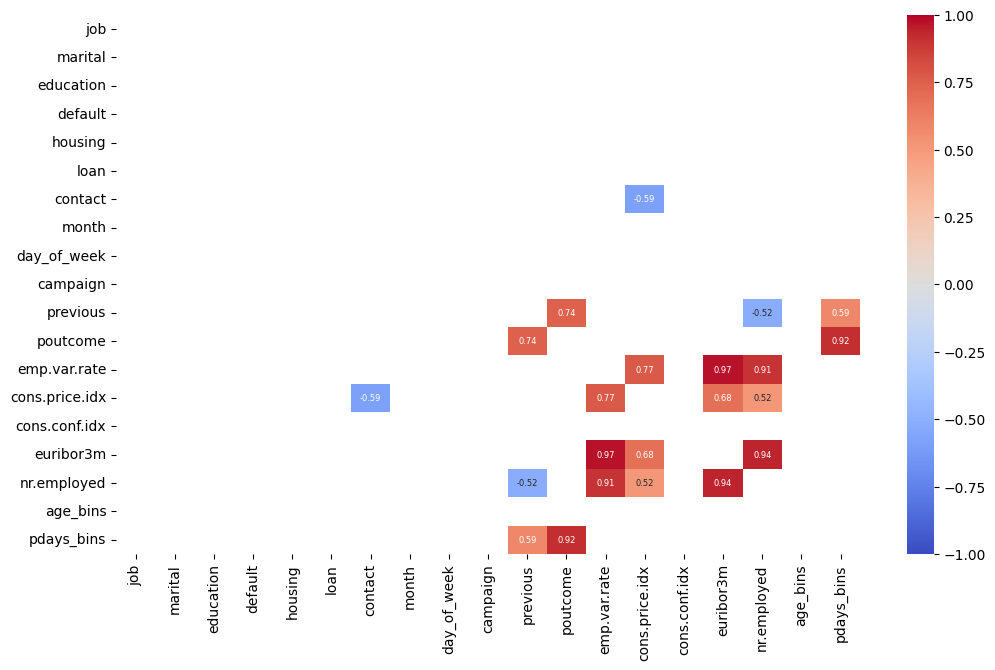

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.heatmap(mcorr[((mcorr >= .5) | (mcorr <= -.5)) & (mcorr != 1.0)], vmax=1.0, vmin=-1.0, cmap=sns.color_palette("coolwarm", as_cmap=True), ax=ax, annot=True, annot_kws={'fontsize': 6})

We have features with high correlation which leads us to multicollinearity problem if using LogisticRegression.  
`euribor3m` is highly correlated with `nr.employed` and `emp.var.rate`. We can drop 2 out of 3 to evade multicollinearity problem when using Logistic Regression model and save all of them when using any of the Forest models  
Also `pdays_bins` is highly correlated with `poutcome`. But in this case we will not drop any of it to see which one will influence more

## 4. Oversampling train dataset

In [33]:
rand_oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = rand_oversampler.fit_resample(X_train, y_train)

In [34]:
print('Len after oversampling: ', X_train_resampled.shape, y_train_resampled.shape)
print('Pos / neg outcomes ratio:\n', y_train_resampled.value_counts() / len(y_train_resampled))

Len after oversampling:  (51166, 19) (51166,)
Pos / neg outcomes ratio:
 0    0.5
1    0.5
Name: y, dtype: float64


## 5. Loading test dataset

In [35]:
filename = 'datasets/bank-test.csv'
df_test = pd.read_csv(filename)
df_test.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,49,technician,divorced,unknown,no,no,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
1,56,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
2,35,technician,single,professional.course,no,no,no,telephone,jun,fri,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.947,5228.1,no
3,32,blue-collar,married,basic.9y,unknown,no,no,telephone,may,fri,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
4,27,unknown,single,university.degree,no,yes,no,cellular,jun,wed,...,4,3,2,success,-1.7,94.055,-39.8,0.767,4991.6,yes


In [36]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12357 entries, 0 to 12356
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             12357 non-null  int64  
 1   job             12357 non-null  object 
 2   marital         12357 non-null  object 
 3   education       12357 non-null  object 
 4   default         12357 non-null  object 
 5   housing         12357 non-null  object 
 6   loan            12357 non-null  object 
 7   contact         12357 non-null  object 
 8   month           12357 non-null  object 
 9   day_of_week     12357 non-null  object 
 10  duration        12357 non-null  int64  
 11  campaign        12357 non-null  int64  
 12  pdays           12357 non-null  int64  
 13  previous        12357 non-null  int64  
 14  poutcome        12357 non-null  object 
 15  emp.var.rate    12357 non-null  float64
 16  cons.price.idx  12357 non-null  float64
 17  cons.conf.idx   12357 non-null 

In [37]:
# encoding and separating target value
df_test['y'] = df_test['y'].map({'yes': 1, 'no': 0})
y_test = df_test['y']

df_test = df_test.drop(columns='y')
df_test.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
8410,49,blue-collar,married,basic.4y,unknown,no,no,telephone,jun,fri,115,1,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
5135,33,unemployed,single,university.degree,no,yes,no,telephone,may,tue,127,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4797,26,unemployed,single,university.degree,no,yes,no,cellular,apr,tue,168,1,999,0,nonexistent,-1.8,93.075,-47.1,1.423,5099.1
8817,24,blue-collar,single,basic.9y,no,yes,no,cellular,jul,wed,590,3,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
8567,44,blue-collar,single,basic.9y,no,yes,no,cellular,may,mon,536,2,999,1,failure,-1.8,92.893,-46.2,1.244,5099.1


In [38]:
y_test.shape

(12357,)

In [39]:
print_real_nans_ratio(df_test, cat_nan_equiv=cat_nan_equiv, num_nan_equiv=num_nan_equiv)

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------
job (`unknown`) 	90 	0.7%
marital (`unknown`) 	22 	0.2%
education (`unknown`) 	497 	4.0%
default (`unknown`) 	2546 	20.6%
housing (`unknown`) 	283 	2.3%
loan (`unknown`) 	283 	2.3%
duration (`999`) 	1 	0.0%
pdays (`999`) 	11939 	96.6%


In [40]:
X_test = processing_pipeline.transform(df_test)
X_test['age_bins'] = pd.to_numeric(X_test['age_bins'])
X_test['pdays_bins'] = pd.to_numeric(X_test['pdays_bins'])
X_test.sample(5)

,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,age_bins,pdays_bins
7870,-0.511972,-0.120888,-0.070196,0.150267,-0.027129,-0.002562,0.304089,-0.598223,0.065041,0.046585,-0.276437,-0.276437,-1.8,92.893,-46.2,1.327,5099.1,-0.333015,-0.222954
1272,-0.511972,0.255020,-0.070196,0.150267,-0.027129,-0.002562,-0.812190,-0.598223,0.014815,0.145492,-0.276437,-0.276437,1.1,93.994,-36.4,4.856,5191.0,0.054106,-0.222954
6058,1.166204,0.255020,-0.043414,0.150267,0.021394,-0.002562,0.304089,1.773354,0.065041,-0.041643,-0.276437,-0.276437,-3.0,92.713,-33.0,0.712,5023.5,0.684230,-0.222954
5403,-0.050266,0.255020,-0.043414,0.150267,0.031584,0.031584,-0.812190,-0.112177,0.033534,-0.041643,-0.276437,-0.276437,1.4,94.465,-41.8,4.864,5228.1,-0.333015,-0.222954
5367,-0.368015,0.255020,-0.043414,0.150267,-0.027129,-0.002562,0.304089,0.674491,-0.014867,0.145492,-0.276437,-0.276437,-1.8,93.075,-47.1,1.405,5099.1,0.054106,-0.222954


In [41]:
X_test.isna().sum()

job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
age_bins          0
pdays_bins        0
dtype: int64

In [42]:
print_real_nans_ratio(X_test, cat_nan_equiv=cat_nan_equiv, num_nan_equiv=num_nan_equiv)

Calculating real NaNs ratio using `unknown` and `999` keyvalues:
Column (value) 	Nvalues 	Ratio
----------------------------------------


## 5. Testing dataset on models

In [43]:
import sklearn as skl
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline as imbPipeline

import catboost as cb
import xgboost as xgb
import lightgbm as lgb

In [44]:
def show_model_results(model, train_set, test_set):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    conf_matrix_train = ConfusionMatrixDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 0])
    roc_curve_train = RocCurveDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 1])
    pr_curve_train = PrecisionRecallDisplay.from_estimator(estimator=model, X=train_set[0], y=train_set[1], ax=axs[0, 2])
    conf_matrix_test = ConfusionMatrixDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 0])
    roc_curve_test = RocCurveDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 1])
    pr_curve_test = PrecisionRecallDisplay.from_estimator(estimator=model, X=test_set[0], y=test_set[1], ax=axs[1, 2])
    print('Scores:')
    print('Indicator  \tTrain \tTest')
    print('='*40)
    print('Accuracy:  \t{:.4f} \t{:.4f}'.format(accuracy_score(train_set[1], model.predict(train_set[0])), accuracy_score(test_set[1], model.predict(test_set[0]))))
    print('Precision: \t{:.4f} \t{:.4f}'.format(precision_score(train_set[1], model.predict(train_set[0])), precision_score(test_set[1], model.predict(test_set[0]))))
    print('Recall:    \t{:.4f} \t{:.4f}'.format(recall_score(train_set[1], model.predict(train_set[0])), recall_score(test_set[1], model.predict(test_set[0]))))
    print('F1:        \t{:.4f} \t{:.4f}'.format(f1_score(train_set[1], model.predict(train_set[0])), f1_score(test_set[1], model.predict(test_set[0]))))

In [45]:
dummy_clf = DummyClassifier(strategy='prior')

In [46]:
dummy_clf.fit(X=X_train, y=y_train)

DummyClassifier()

Scores:
Indicator  	Train 	Test
Accuracy:  	0.8873 	0.8874
Precision: 	0.0000 	0.0000
Recall:    	0.0000 	0.0000
F1:        	0.0000 	0.0000


d:\Work\venv\dsml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Work\venv\dsml\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


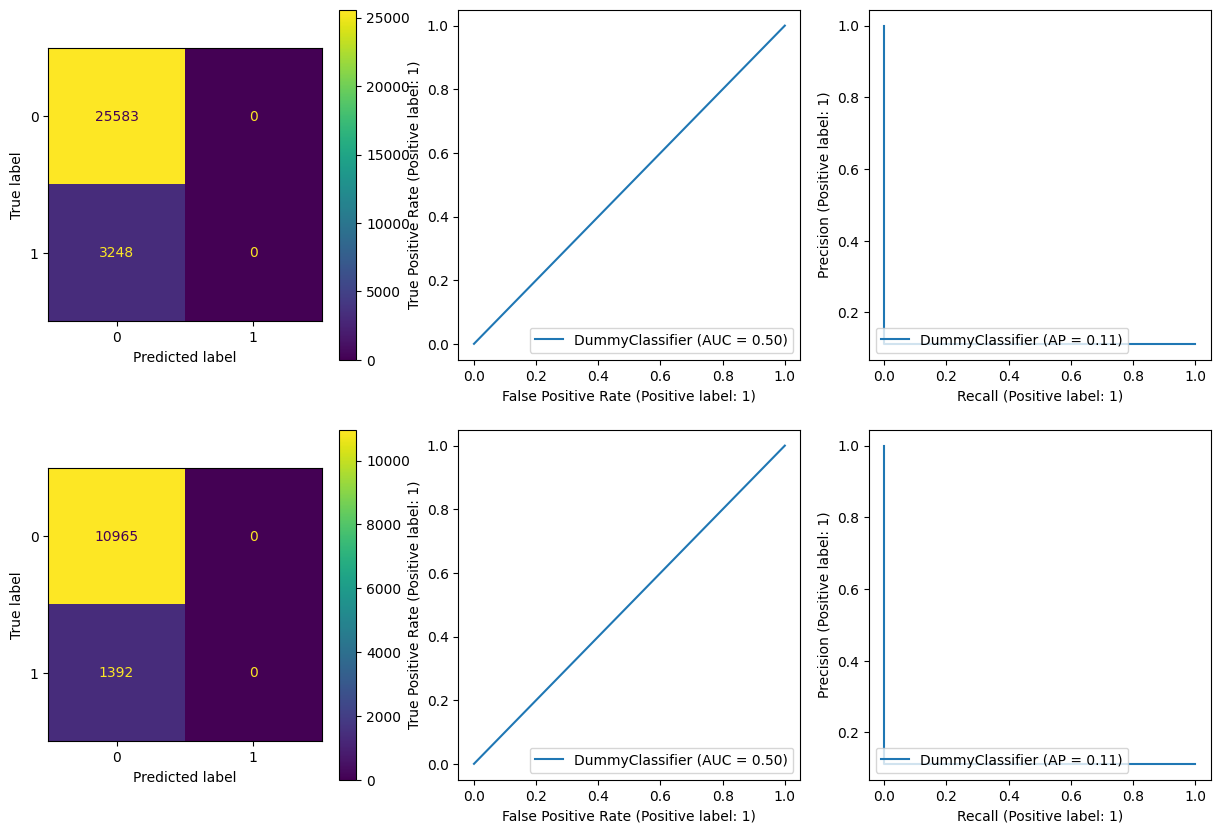

In [47]:
show_model_results(dummy_clf, train_set=[X_train, y_train], test_set=[X_test, y_test])

### 5.1. Logistic Regression

In [48]:
skl.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [49]:
lr_clf = imbPipeline([
    ('smote', SMOTE(random_state=42)), # auto-adding observation to make balanced trainset
    ('scale', MinMaxScaler()),
    ('clf', LogisticRegression(penalty='l1', C=1.0, solver='liblinear'))
])

lr_clf_w = imbPipeline([
    #('smote', SMOTE(random_state=42)),
    ('scale', MinMaxScaler()),
    ('clf', LogisticRegression(penalty='l1', C=1.0, solver='liblinear', class_weight='balanced')) #, class_weight={0: 0.125, 1: 1.0}
])

param_grid = [
    dict(clf__C=np.logspace(-4, 1, 6), clf__solver=['lbfgs', 'newton-cg'], clf__penalty=['l2'], ),
    dict(clf__C=np.logspace(-4, 1, 6), clf__solver=['liblinear'], clf__penalty=['l1','l2'], ),
    dict(clf__C=np.logspace(-4, 1, 6), clf__solver=['newton-cholesky', 'sag'], clf__penalty=['l2'], ),
    dict(clf__C=np.logspace(-4, 1, 6), clf__solver=['saga'], clf__penalty=['l1','l2', 'elasticnet'], ),
]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [50]:
lr_grid = GridSearchCV(lr_clf, param_grid=param_grid, cv=kfold, n_jobs=1, return_train_score=True, scoring= 'recall') # verbose=2, 
lr_grid.fit(X_train, y_train)

d:\Work\venv\dsml\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Work\venv\dsml\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Work\venv\dsml\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "d:\Work\venv\dsml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "d:\Wor

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scale', MinMaxScaler()),
                                       ('clf',
                                        LogisticRegression(penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=1,
             param_grid=[{'clf__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'clf__penalty': ['l2'],
                          'clf__solver': ['lbfgs', 'new...
                         {'clf__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'clf__penalty': ['l1', 'l2'],
                          'clf__solver': ['liblinear']},
                         {'clf__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'clf__penalty': ['l2'],
                          'clf__solver': ['newton-cholesky', 'sag']},
                         {'clf__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'clf__penalty': ['l1', 'l2', 'elasticnet'],
                          'clf__solver': ['saga']}],
             return_train_score=True, scoring='recall')

Scores:
Indicator  	Train 	Test
Accuracy:  	0.7174 	0.7258
Precision: 	0.2412 	0.2525
Recall:    	0.7029 	0.7313
F1:        	0.3591 	0.3754


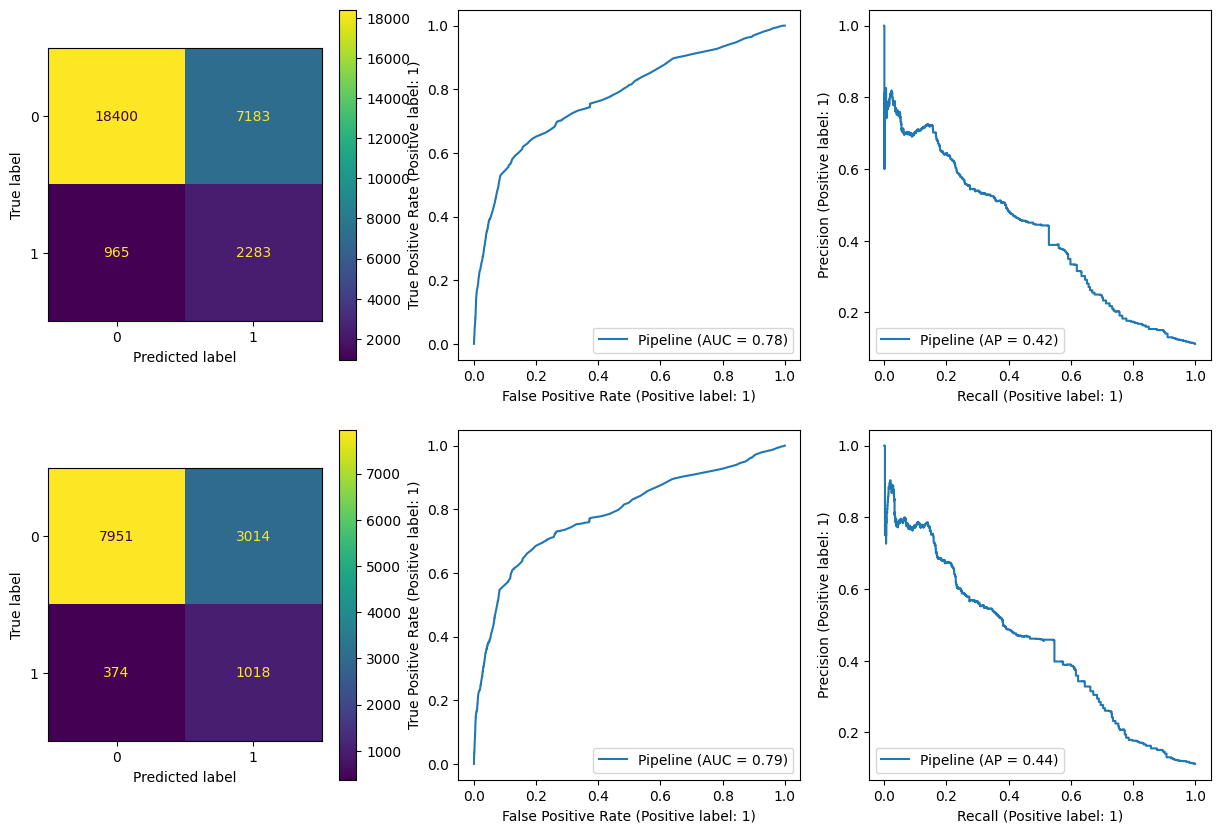

In [51]:
show_model_results(lr_grid.best_estimator_, train_set=[X_train, y_train], test_set=[X_test, y_test])

In [52]:
lr_grid_w = GridSearchCV(lr_clf_w, param_grid=param_grid, cv=kfold, n_jobs=1, return_train_score=True, scoring= 'recall') # verbose=2, 
lr_grid_w.fit(X_train, y_train)

d:\Work\venv\dsml\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Work\venv\dsml\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Work\venv\dsml\lib\site-packages\imblearn\pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "d:\Work\venv\dsml\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "d:\Wor

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=1,
             param_grid=[{'clf__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'clf__penalty': ['l2'],
                          'clf__solver': ['lbfgs', 'newton-cg']},
                         {'clf__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'clf__penalty': ['l1', 'l2'],
                          'clf__solver': ['liblinear']},
                         {'clf__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'clf__penalty': ['l2'],
                          'clf__solver': ['newton-cholesky', 'sag']},
                         {'clf__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'clf__penalty': ['l1', 'l2', 'elasticnet'],
                          'clf__solver': ['saga']}],
             return_train_score=True, scoring='recall')

Scores:
Indicator  	Train 	Test
Accuracy:  	0.7174 	0.7258
Precision: 	0.2412 	0.2525
Recall:    	0.7029 	0.7313
F1:        	0.3591 	0.3754


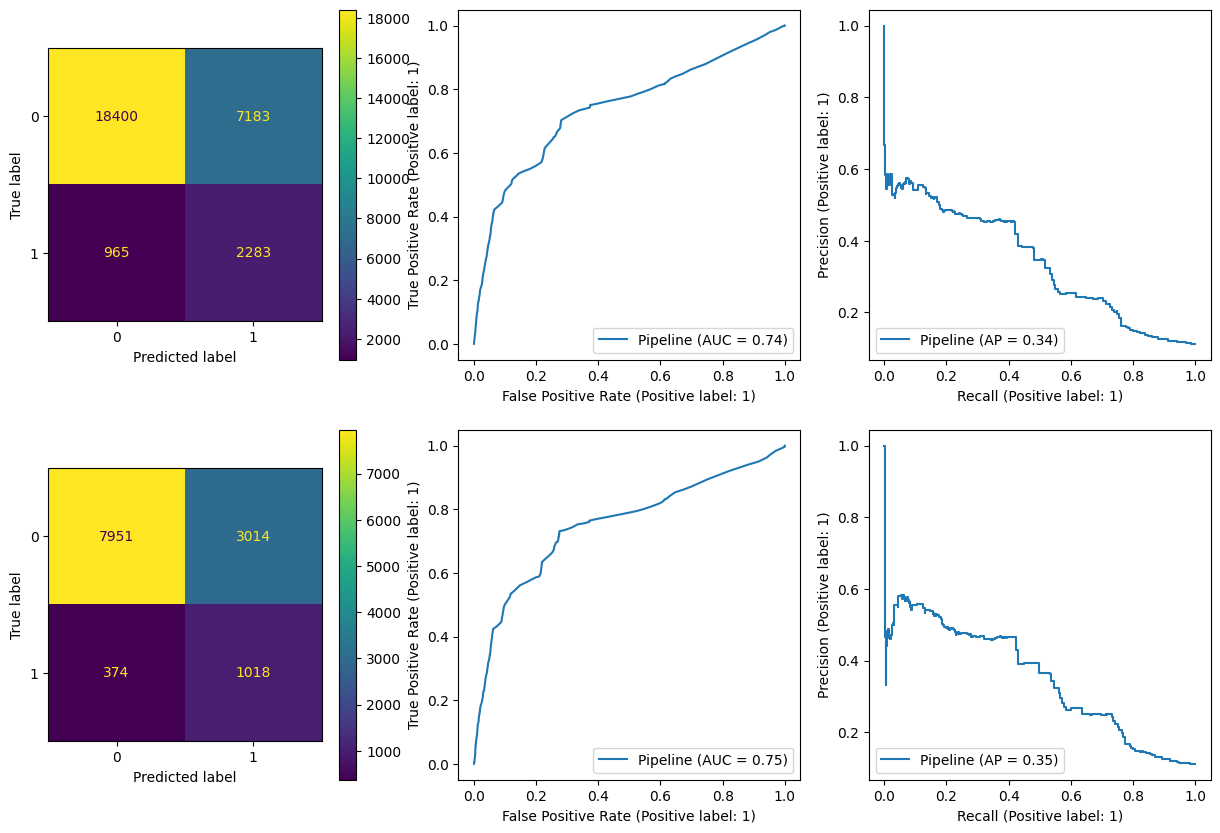

In [53]:
show_model_results(lr_grid_w.best_estimator_, train_set=[X_train, y_train], test_set=[X_test, y_test])

### lightgbm

In [54]:
lgb_clf = imbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.001, n_estimators=500, objective='binary', random_state=42)),
])

lgb_clf_w = imbPipeline([
    #('smote', SMOTE(random_state=42)),
    ('clf', lgb.LGBMClassifier(boosting_type='dart', learning_rate=0.001, n_estimators=500, objective='binary', random_state=42, is_unbalance=True)),
])

param_grid = dict(
    clf__learning_rate=np.logspace(-4, 0, 10),
    #clf__boosting_type=['gbdt', 'dart', 'goss', 'rf'],
    #clf__n_estimators=range(50, 501, 100),
    #clf__penalty=['l1','l2', 'elasticnet'],
)

lgb_grid = GridSearchCV(lgb_clf, param_grid=param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='recall', return_train_score=True)
lgb_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        LGBMClassifier(boosting_type='dart',
                                                       learning_rate=0.001,
                                                       n_estimators=500,
                                                       objective='binary',
                                                       random_state=42))]),
             param_grid={'clf__learning_rate': array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00])},
             return_train_score=True, scoring='recall')

In [55]:
lgb_grid.best_estimator_

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 LGBMClassifier(boosting_type='dart',
                                learning_rate=0.002154434690031882,
                                n_estimators=500, objective='binary',
                                random_state=42))])

Scores:
Indicator  	Train 	Test
Accuracy:  	0.8605 	0.8652
Precision: 	0.4146 	0.4300
Recall:    	0.5788 	0.6049
F1:        	0.4831 	0.5027


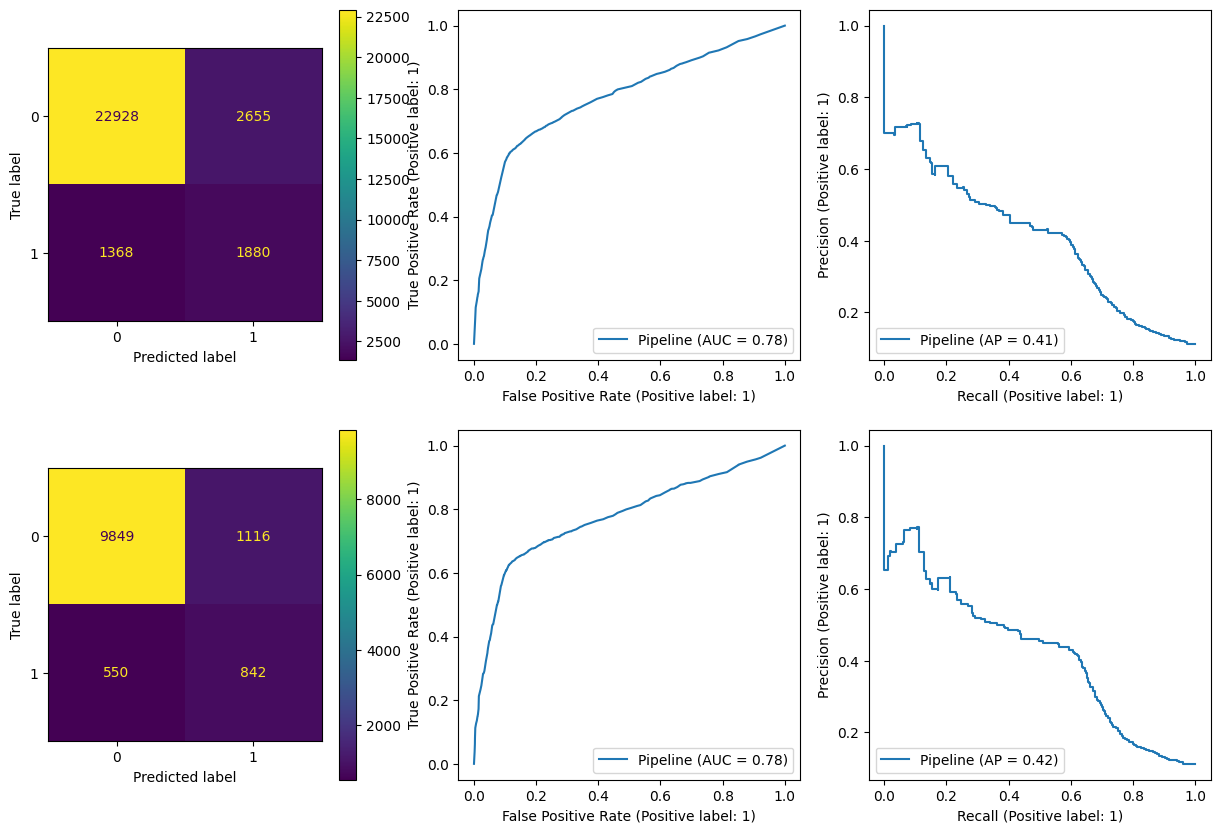

In [56]:
show_model_results(lgb_grid.best_estimator_, train_set=[X_train, y_train], test_set=[X_test, y_test])

In [57]:
lgb_grid_w = GridSearchCV(lgb_clf_w, param_grid=param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='recall', return_train_score=True)
lgb_grid_w.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        LGBMClassifier(boosting_type='dart',
                                                       is_unbalance=True,
                                                       learning_rate=0.001,
                                                       n_estimators=500,
                                                       objective='binary',
                                                       random_state=42))]),
             param_grid={'clf__learning_rate': array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00])},
             return_train_score=True, scoring='recall')

Scores:
Indicator  	Train 	Test
Accuracy:  	0.8454 	0.8475
Precision: 	0.3883 	0.3936
Recall:    	0.6475 	0.6537
F1:        	0.4855 	0.4914


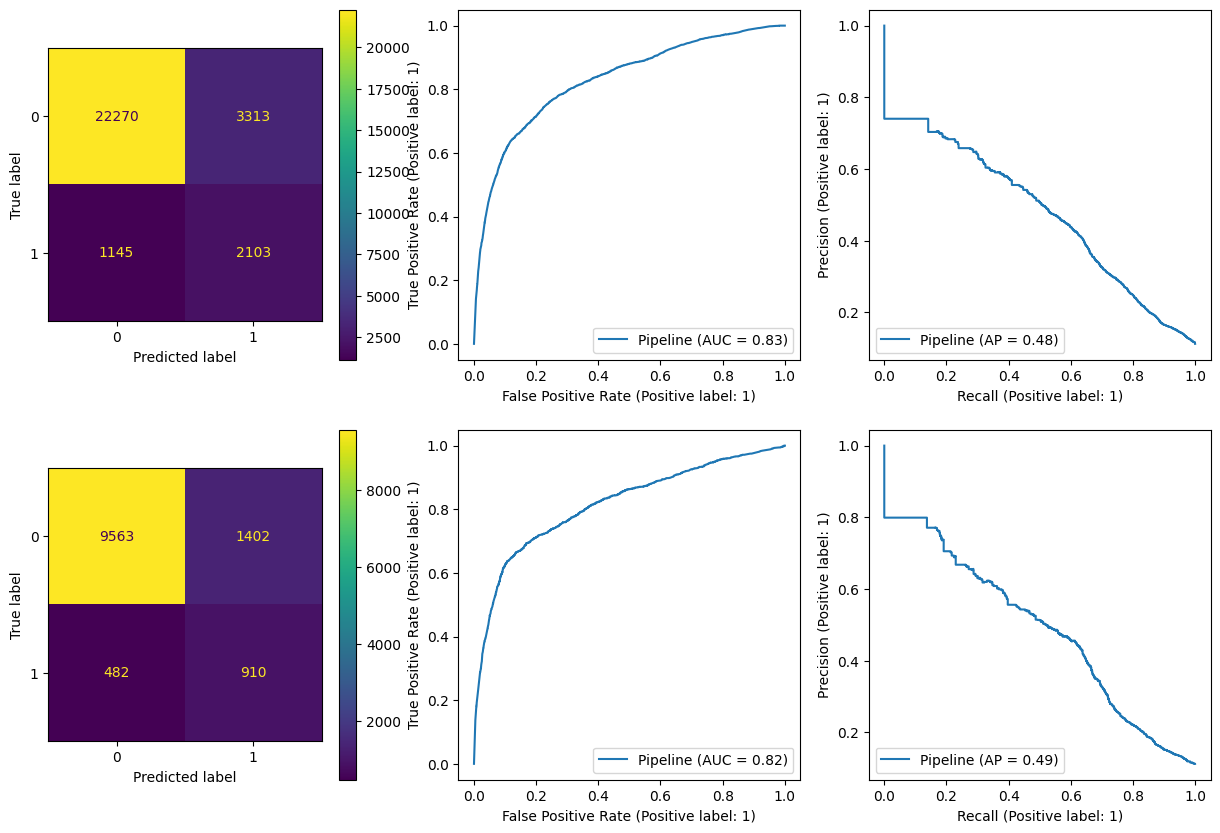

In [58]:
show_model_results(lgb_grid_w.best_estimator_, train_set=[X_train, y_train], test_set=[X_test, y_test])

In [59]:
learning_rate_opt = np.round(lgb_grid.best_estimator_['clf'].learning_rate, 3)
learning_rate_opt

0.002

In [60]:
lgb_grid.cv_results_

{'mean_fit_time': array([12.09659562, 12.2905035 , 11.56516132, 10.79660506, 10.83620234,
        10.19039826, 10.23259892,  9.50359979,  7.49860044,  6.98859997]),
 'std_fit_time': array([0.67573387, 1.48542467, 1.00354364, 0.21506002, 0.37941014,
        0.39864967, 0.40593992, 0.10282419, 0.48158036, 0.95361815]),
 'mean_score_time': array([0.04139719, 0.04540291, 0.04099727, 0.04180012, 0.04339685,
        0.0426012 , 0.04460073, 0.04480019, 0.04259892, 0.04320283]),
 'std_score_time': array([0.00949215, 0.00949587, 0.00227651, 0.003816  , 0.00206459,
        0.00249663, 0.00287132, 0.00172005, 0.00215459, 0.00412347]),
 'param_clf__learning_rate': masked_array(data=[0.0001, 0.0002782559402207126, 0.000774263682681127,
                    0.002154434690031882, 0.005994842503189409,
                    0.016681005372000592, 0.046415888336127774,
                    0.12915496650148828, 0.3593813663804626, 1.0],
              mask=[False, False, False, False, False, False, False, Fal

In [61]:
data = lgb_grid.cv_results_
data

{'mean_fit_time': array([12.09659562, 12.2905035 , 11.56516132, 10.79660506, 10.83620234,
        10.19039826, 10.23259892,  9.50359979,  7.49860044,  6.98859997]),
 'std_fit_time': array([0.67573387, 1.48542467, 1.00354364, 0.21506002, 0.37941014,
        0.39864967, 0.40593992, 0.10282419, 0.48158036, 0.95361815]),
 'mean_score_time': array([0.04139719, 0.04540291, 0.04099727, 0.04180012, 0.04339685,
        0.0426012 , 0.04460073, 0.04480019, 0.04259892, 0.04320283]),
 'std_score_time': array([0.00949215, 0.00949587, 0.00227651, 0.003816  , 0.00206459,
        0.00249663, 0.00287132, 0.00172005, 0.00215459, 0.00412347]),
 'param_clf__learning_rate': masked_array(data=[0.0001, 0.0002782559402207126, 0.000774263682681127,
                    0.002154434690031882, 0.005994842503189409,
                    0.016681005372000592, 0.046415888336127774,
                    0.12915496650148828, 0.3593813663804626, 1.0],
              mask=[False, False, False, False, False, False, False, Fal

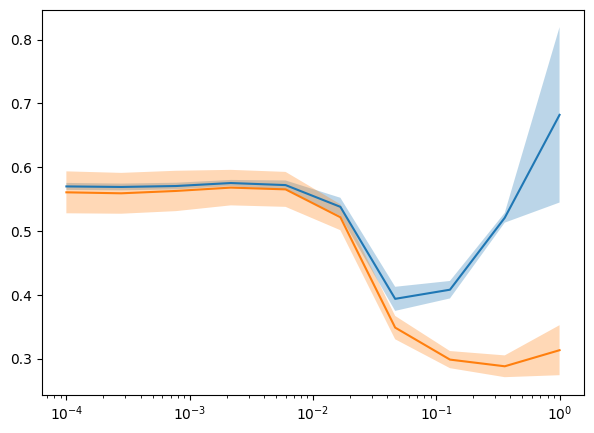

In [62]:
x = []
for param in data['params']:
    x.append(list(param.values())[0])

#train_score_std = data['std_train_score']
#test_score_mean = data['mean_test_score']
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(x, data['mean_train_score'])
ax.fill_between(x, data['mean_train_score']-data['std_train_score'], data['mean_train_score']+data['std_train_score'], alpha=0.3)
ax.plot(x, data['mean_test_score'])
ax.fill_between(x, data['mean_test_score']-data['std_test_score'], data['mean_test_score']+data['std_test_score'], alpha=0.3)
ax.set_xscale('log')

### xgboost

In [111]:
xgb_clf = imbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', xgb.XGBClassifier(n_estimators=500)),
])

xgb_clf_w = imbPipeline([
    #('smote', SMOTE(random_state=42)),
    ('clf', xgb.XGBClassifier(n_estimators=500, scale_pos_weight=(len(y_train) - y_train.sum())/y_train.sum())),
])

param_grid = dict(
    clf__learning_rate=np.logspace(-4, 0, 10),
    #clf__penalty=['l1','l2', 'elasticnet'],
)

xgb_grid = GridSearchCV(xgb_clf, param_grid=param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='recall')
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=Non...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=500,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'clf__learning_rate': array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00])},
             scoring='recall')

In [112]:
xgb_grid.best_estimator_

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.002154434690031882, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

Scores:
Indicator  	Train 	Test
Accuracy:  	0.8792 	0.8812
Precision: 	0.4684 	0.4764
Recall:    	0.5363 	0.5510
F1:        	0.5001 	0.5110


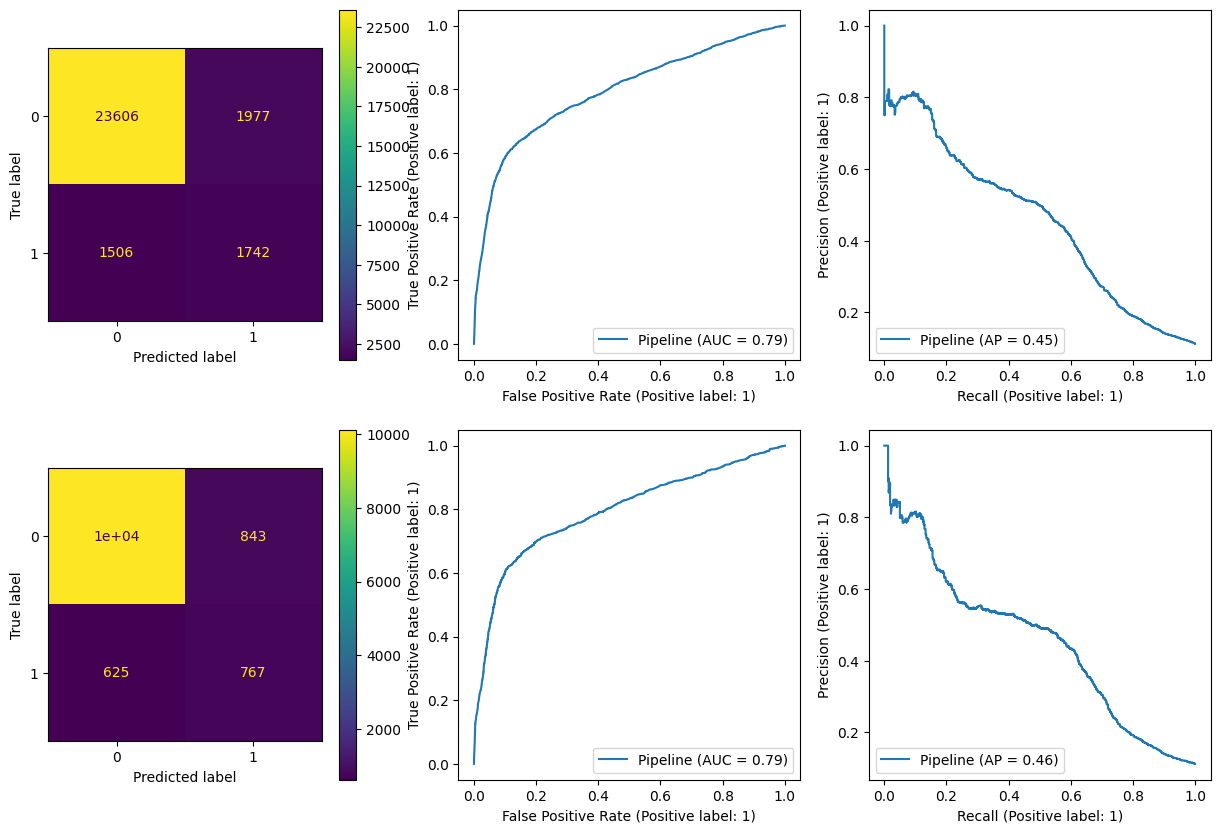

In [113]:
show_model_results(model=xgb_grid.best_estimator_, train_set=[X_train, y_train], test_set=[X_test, y_test])

In [114]:
xgb_grid_w = GridSearchCV(xgb_clf_w, param_grid=param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='recall')
xgb_grid_w.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_pol...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=500,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'clf__learning_rate': array([1.00000000e-04, 2.78255940e-04, 7.74263683e-04, 2.15443469e-03,
       5.99484250e-03, 1.66810054e-02, 4.64158883e-02, 1.29154967e-01,
       3.59381366e-01, 1.00000000e+00])},
             scoring='recall')

Scores:
Indicator  	Train 	Test
Accuracy:  	0.8462 	0.8457
Precision: 	0.3906 	0.3896
Recall:    	0.6518 	0.6530
F1:        	0.4885 	0.4881


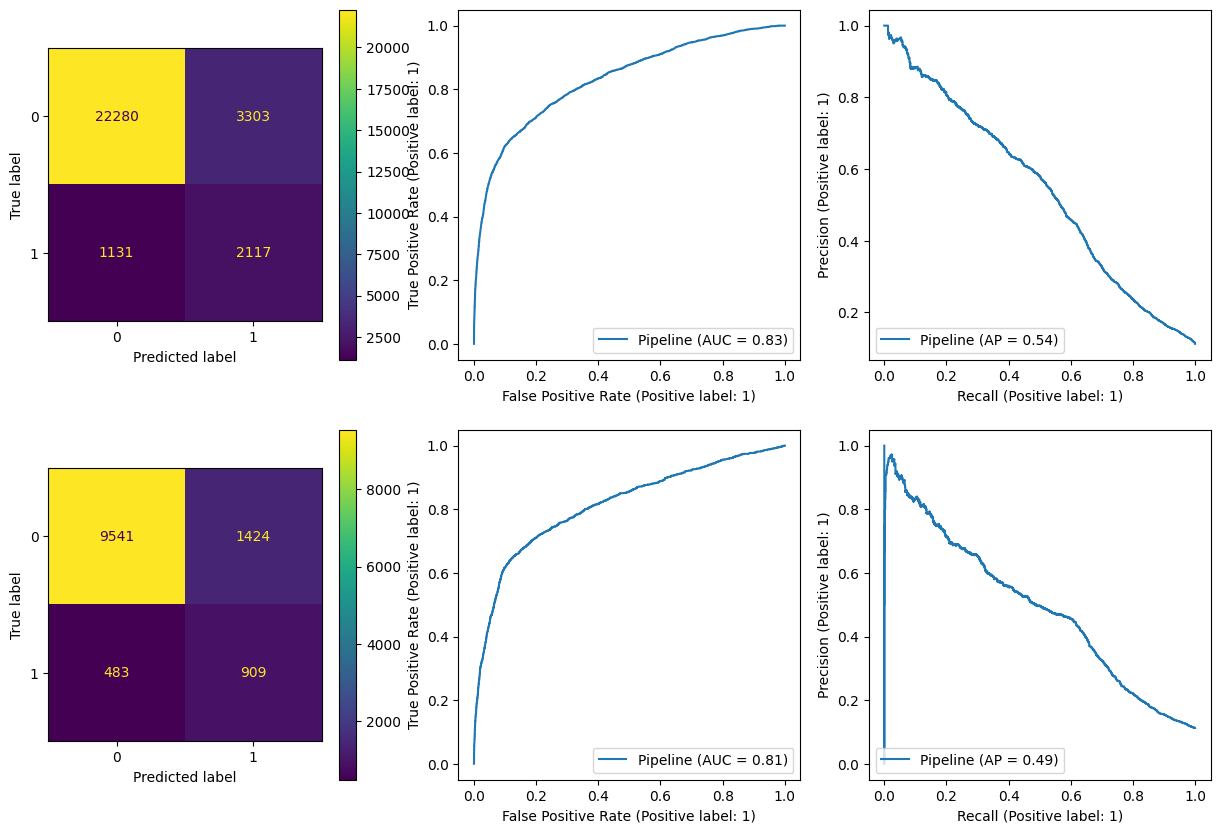

In [115]:
show_model_results(model=xgb_grid_w.best_estimator_, train_set=[X_train, y_train], test_set=[X_test, y_test])

### Multigoal Search

In [125]:
param_grid = [
    dict(clf__C=np.logspace(-4, 1, 6), clf__solver=['lbfgs'], clf__penalty=['l2'], ),#, 'newton-cg', 'sag'
    #dict(clf__C=np.logspace(-4, 1, 6), clf__solver=['liblinear'], clf__penalty=['l1','l2'], ),
    #dict(clf__C=np.logspace(-4, 1, 6), clf__solver=['saga'], clf__penalty=['l1','l2', 'elasticnet'], ),
]

scoring = {'AUC': 'roc_auc', 'Recall': 'recall'}

In [126]:
lr_grid_multi = GridSearchCV(lr_clf, param_grid=param_grid, cv=kfold, n_jobs=1, return_train_score=True, scoring=scoring, refit='Recall') # verbose=2, 
lr_grid_multi.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scale', MinMaxScaler()),
                                       ('clf',
                                        LogisticRegression(penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=1,
             param_grid=[{'clf__C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                          'clf__penalty': ['l2'], 'clf__solver': ['lbfgs']}],
             refit='Recall', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Recall': 'recall'})

In [127]:
results = lr_grid_multi.cv_results_
results

{'mean_fit_time': array([0.21960583, 0.16800141, 0.24939842, 0.32760587, 0.38040123,
        0.36259665]),
 'std_fit_time': array([0.04912398, 0.00424565, 0.01540176, 0.02714841, 0.02434379,
        0.03392297]),
 'mean_score_time': array([0.01299109, 0.00959654, 0.01179819, 0.01079302, 0.00999804,
        0.01000257]),
 'std_score_time': array([0.00167253, 0.00080029, 0.00132012, 0.00132415, 0.000892  ,
        0.00141424]),
 'param_clf__C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__penalty': masked_array(data=['l2', 'l2', 'l2', 'l2', 'l2', 'l2'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__solver': masked_array(data=['lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
    

In [128]:
results['param_clf__C'].data

array([0.0001, 0.001, 0.01, 0.1, 1.0, 10.0], dtype=object)

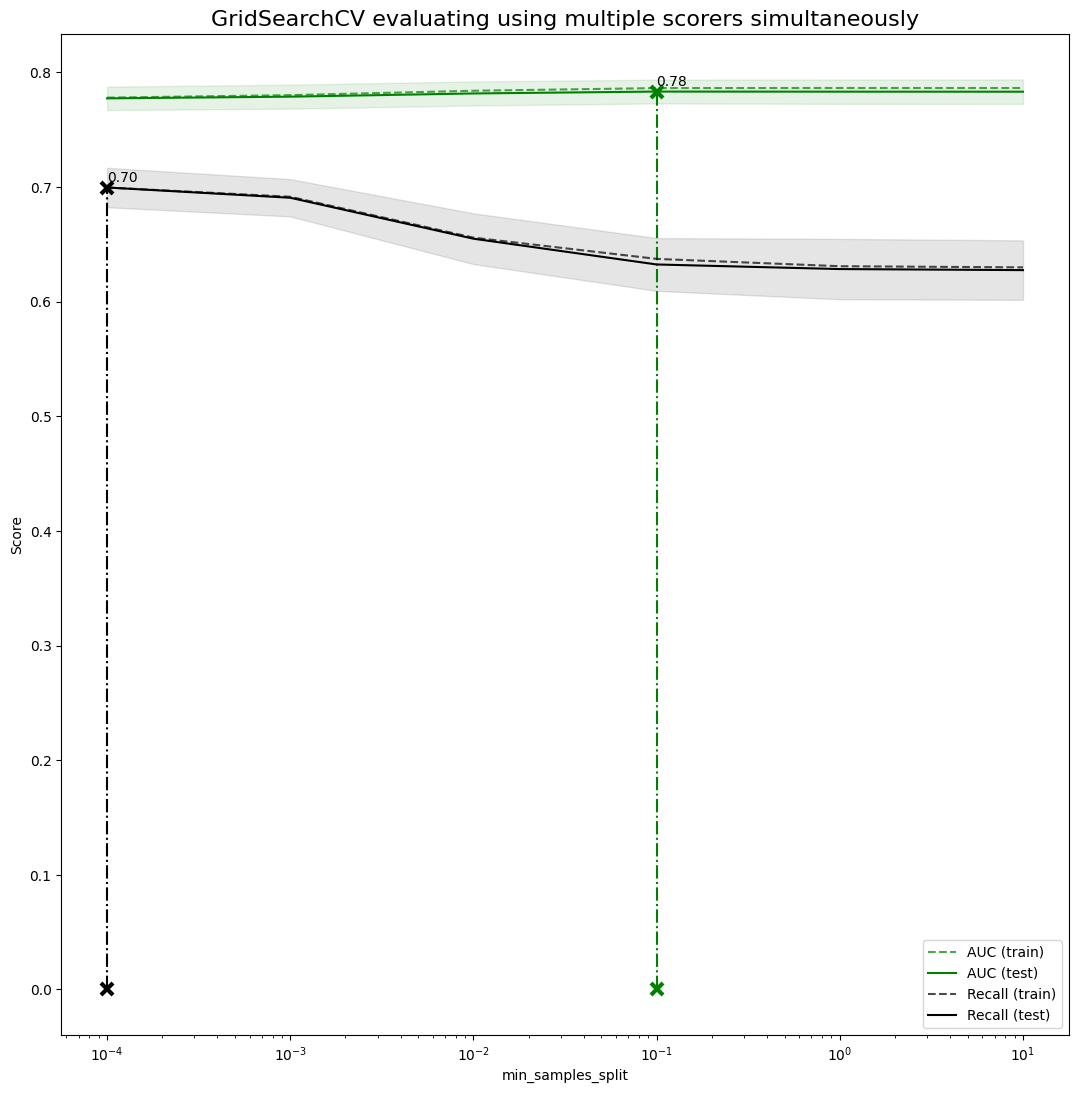

In [130]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("C")
plt.ylabel("Score")

ax = plt.gca()
#ax.set_xlim(0, 402)
#ax.set_ylim(0.73, 1)
ax.set_xscale('log')
# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_clf__C'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ["g", "k"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()